In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output

In [20]:
# Simulation parameters

v0           = 1.0      # velocity
v_max        = 1.5      # max velocity
lambda_c     = 0.05     # centring strength
lambda_av    = 0.1      # avoiding strength
lambda_m     = 0.2      # matching strength
lambda_at    = 0.04     # attraction strength
lambda_r     = 0.15      # repulsion strength
eta          = 0.3      # random fluctuation in angle (in radians)
L            = 20       # size of box
R            = 1        # interaction radius
Rsq          = R**2     # square of the interaction radius
r            = 0.2      # separation distance
dt           = 0.1      # time step
Nt           = 100      # number of time steps
N_birds      = 3000     # number of birds
drone_r      = 3.0      # repulsion radius
attract_r    = 10.0      # attraction radius to farm 

restricted_area = (8, 12, 8, 12)

np.random.seed(13)      # set the random number generator seed

In [3]:
def initialize_birds(restricted_area=None):
    '''
    Set initial positions, direction, and velocities, avoiding restricted areas if 
    there are any
    '''
    x = np.zeros((N_birds, 1))
    y = np.zeros((N_birds, 1))

    for bird in range(N_birds):
        while True:
            x_temp = np.random.rand() * L
            y_temp = np.random.rand() * L
            
            if restricted_area:
                x_min, x_max, y_min, y_max = restricted_area
                if x_min <= x_temp <= x_max and y_min <= y_temp <= y_max:
                    continue  
            
            x[bird] = x_temp
            y[bird] = y_temp
            break
    
    # restricted area centre
    rx = (x_max + x_min) / 2
    ry = (y_max + y_min) / 2
    
    # bird velocities
    theta = 2 * np.pi * np.random.rand(N_birds,1)
    vx = v0 * np.cos(theta)
    vy = v0 * np.sin(theta)

    return x, y, vx, vy, rx, ry

In [4]:
def initialize_drones(drone_x, drone_y):
    
    N_drones = len(drone_x)

    return N_drones, drone_x, drone_y 

In [5]:
def apply_boundary_conditions(x, y):
    '''
    Apply periodic boundary conditions
    '''
    x = x % L
    y = y % L
    return x, y

In [6]:
def update_positions(x, y, vx, vy):
    '''
    Update the positions moving dt in the direction of the velocity
    and applying the boundary conditions
    '''
    
    # update positions
    x += vx*dt
    y += vy*dt
    
    # apply boundary conditions
    x, y = apply_boundary_conditions(x,y)
    return x, y

In [7]:
def get_centering_velocities(x, y, i, neighbours):
    '''
    Compute the velocity towards the centre of mass of local birds in a
    radius R for bird i
    '''

    neighbour_count = np.sum(neighbours)
        
    x_center = np.sum(x[neighbours]) / neighbour_count
    y_center = np.sum(y[neighbours]) / neighbour_count

    vcx = lambda_c * (x_center - x[i])
    vcy = lambda_c * (y_center - y[i])

    return vcx, vcy

In [8]:
def get_avoiding_velocities(x, y, i):
    '''
    Compute the velocity away from potential colisions for bird i with
    avoidance radius r
    '''
    
    too_close = (x-x[i])**2 + (y-y[i])**2 < r**2
    vavx = lambda_av * np.sum(x[i] - x[too_close])
    vavy = lambda_av * np.sum(y[i] - y[too_close])
        
    return vavx, vavy

In [9]:
def get_matching_velocities(x, y, vx, vy, i, neighbours):
    '''
    Compute the average velocity of local birds in a radius R and align with 
    it for bird i
    '''
    neighbours_count = len(neighbours)

    avg_vx = np.sum(vx[neighbours])/neighbours_count
    avg_vy = np.sum(vy[neighbours])/neighbours_count
    
    vmx = lambda_m*(avg_vx - vx[i])
    vmy = lambda_m*(avg_vy - vy[i])
        
    return vmx, vmy

In [10]:
def get_attractive_velocities(x, y, vx, vy, rx, ry, i):
    '''
    Compute the velocity of birds towards the centre of the restricted area
    '''
    
    dx = rx - x[i]
    dy = ry - y[i]
    dist_sq = dx**2 + dy**2
    # If within sight of the farm, move towards it
    if (0 < dist_sq < attract_r**2):
        vatx = lambda_at*dx/np.sqrt(dist_sq)
        vaty = lambda_at*dy/np.sqrt(dist_sq)
        return vatx, vaty
    else:
        return 0., 0.

In [11]:
def get_repulsive_velocities(x, y, drone_x, drone_y, i):
    '''
    Compute the velocity away from drones for bird i with repulsive radius 
    drone_r
    '''
    vrx = 0
    vry = 0

    for drone_index in range(N_drones):
        dx = x[i] - drone_x[drone_index]
        dy = y[i] - drone_y[drone_index]
        dist_sq = dx**2 + dy**2
        # If in range of drone, add the repulsion to the velocity
        if 0 < dist_sq < drone_r**2:
            vrx += lambda_r * dx / dist_sq
            vry += lambda_r * dy / dist_sq
    
    return vrx, vry


In [12]:
def update_velocities(x, y, vx, vy, rx, ry, drone_x, drone_y):
    '''
    Update the velocities for the next time step using the centering, avoiding 
    and matching components 
    '''
    for i in range(N_birds):
        neighbours = (x - x[i])**2 + (y - y[i])**2 < Rsq # Boolean array corresponding to neighbours
        neighbours[i] = 0 # Bird is not a neighbour with itself
        neighbour_count = np.sum(neighbours)
        
        # We only need to do these if the bird has neighbours 
        match neighbour_count:
            case 0:
                vcx, vcy = 0., 0.
                vmx, vmy = 0., 0.
            case _:
                vcx, vcy = get_centering_velocities(x, y, i, neighbours)
                vmx, vmy = get_matching_velocities(x, y, vx, vy, i, neighbours)

        # Avoiding velocities
        vavx, vavy = get_avoiding_velocities(x, y, i)
        # Attraction to farm centre
        vatx, vaty = get_attractive_velocities(x, y, vx, vy, rx, ry, i)
        # Repulsion from drones
        vrx, vry = get_repulsive_velocities(x, y, drone_x, drone_y, i)

        vx[i] += (vcx + vavx + vmx + vatx + vrx + eta*(np.random.rand()-0.5))
        vy[i] += (vcy + vavy + vmy + vaty + vry + eta*(np.random.rand()-0.5))
    
    v_norms = np.sqrt(vx**2 + vy**2)

    normalised_vx = np.minimum(1, v_max / v_norms) * vx
    normalised_vy = np.minimum(1, v_max / v_norms) * vy

    return normalised_vx, normalised_vy

In [13]:
def step(x, y, vx, vy, rx, ry, drone_x, drone_y):
    '''
    Compute a step in the dynamics:
    - update the positions
    - compute the new velocities
    '''
    x,y = update_positions(x, y, vx, vy)
    vx,vy = update_velocities(x, y, vx, vy, rx, ry, drone_x, drone_y)
 
    return x, y, vx, vy

In [14]:
def update_quiver(q, x, y, vx, vy):
    '''
    Update a quiver with new position and velocity information
    This is only used for plotting
    '''
    q.set_offsets(np.column_stack([x,y]))
    q.set_UVC(vx,vy)
    return q

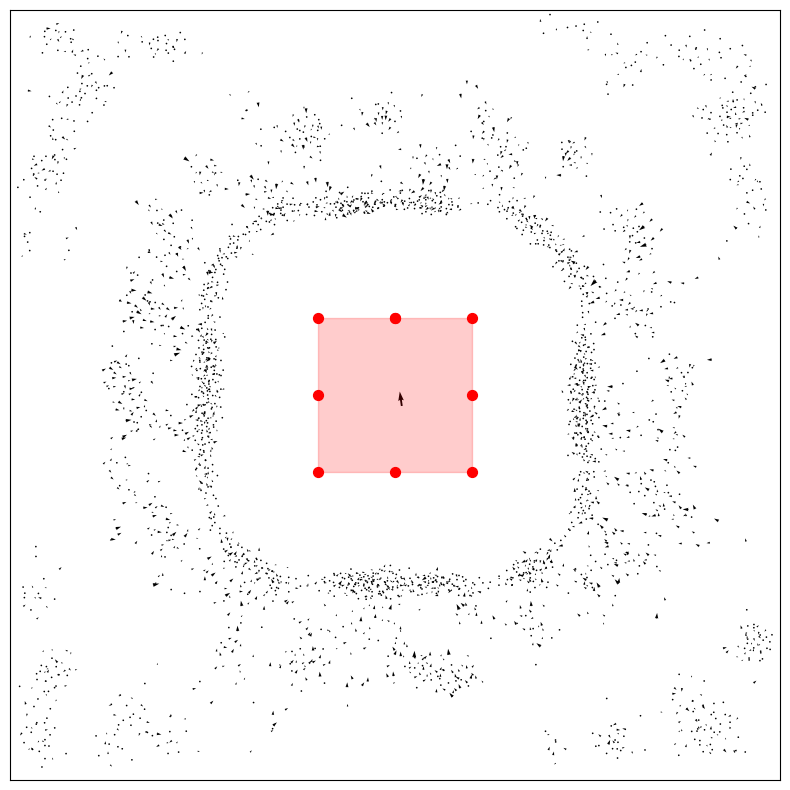

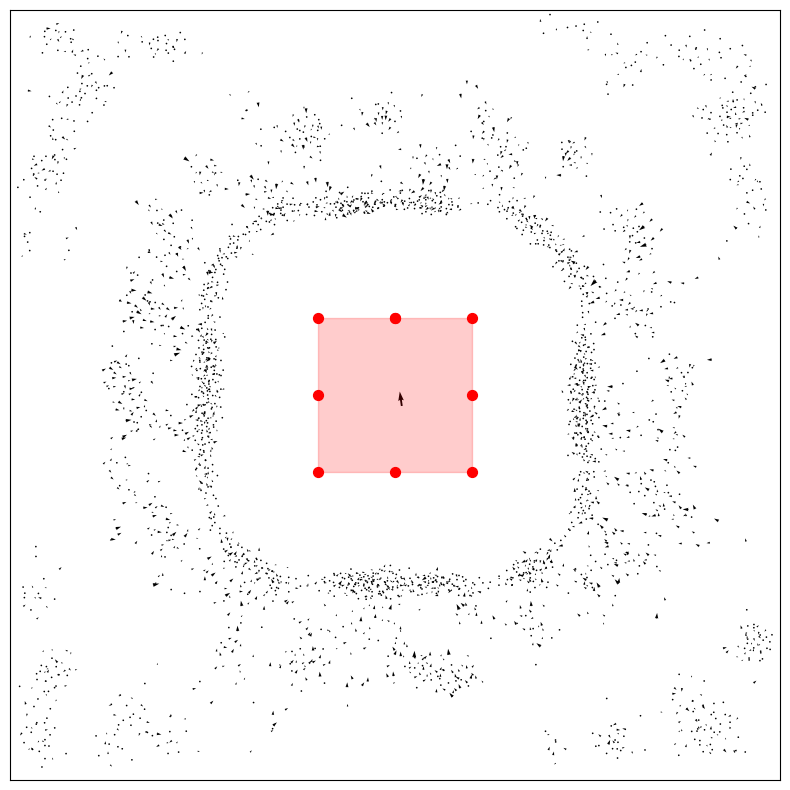

In [21]:
# set up a figure
fig, ax = plt.subplots(figsize = (10, 10))

# get the initial configuration
x, y, vx, vy, rx, ry = initialize_birds(restricted_area)

# set drone locations
drone_x = np.array([8, 10, 12, 12, 12, 10, 8, 8, 10])
drone_y = np.array([12, 12, 12, 8, 10, 12, 8, 10, 8])


N_drones, drone_x, drone_y = initialize_drones(drone_x, drone_y)

# do an initial plot and set up the axes
q = plt.quiver(x, y, vx, vy)
ax.set(xlim=(0, L), ylim=(0, L))
ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax.scatter(drone_x, drone_y, color='red', s=50, marker='o')
ax.fill_between([8, 12], [8, 8], [12, 12], color = "r", alpha = 0.2)

# do each step, updating the quiver and plotting the new one
for iT in range(Nt):

    x, y, vx, vy = step(x, y, vx, vy, rx, ry, drone_x, drone_y)
    q = update_quiver(q, x, y, vx, vy)
    clear_output(wait=True)
    display(fig)